In [366]:
# Please uncomment these to install the modules
# !pip3 install sklearn
# !pip3 install pandas
# !pip3 install matplotlib
# !pip3 install numpy
# !pip3 install mlxtend


# importing required modules
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import warnings
from pyECLAT import ECLAT
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import numpy as np
import json

%matplotlib inline

In [335]:
# disable warning messages
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy of a slice from a DataFrame.")

In [367]:
# opening the movies_metadata & ratings excel file and importing as pandas dataframe object
moviesDf = pd.read_excel("movies_metadata.xlsx")
ratingsDf  = pd.read_excel("ratings.xlsx")

In [371]:
# Constant Values for genres
# These are used to calculate the hashValue for each genre Combinations
# in the excel files
GENRES =  {'Drama':1, 'Comedy' :2 , 'Thriller' : 3, 'Action': 4, 'Romance': 5, 'Horror':6,
           'Crime':7, 'Adventure':8, 'Science Fiction':9, 'Family' : 10, 'Mystery':11, 'Fantasy': 12,
           'Documentary' :13, 'Animation':14, 'Music':15, 'History' : 16, 'War' : 17, 'Western': 18,
           'Foreign' : 19, 'TV Movie': 20}

# Specific values used for testing purpose
movieIndex = 1798
movieID = 4011
userId = 98

In [372]:
# pre-processing dataframes
# removing the unrequired columns
moviesDf = moviesDf.drop('production_companies', axis=1)
moviesDf = moviesDf.drop('release_date', axis=1)
moviesDf = moviesDf.drop('spoken_languages', axis=1)
ratingsDf = ratingsDf.drop('timestamp', axis=1)

In [373]:
# Mapping strings to numbers for genre and languages
# This method is used to hash a given genre list in string format to an int number
def mapToHash(txt):
    genres = json.loads(txt.replace("'", "\""))
    genre_names = [genre['name'] for genre in genres]
    digits = 8 # As maximum genres for a single movie in our database is 8
    hashVal = 0
    
    for i in genre_names:
        hashVal += GENRES[i]*(10**digits)
        digits -= 1
        
    return hashVal

# Mapping all the genres to numbers
moviesDf['genres'] = moviesDf['genres'].apply(mapToHash)

In [374]:
# To make visualization easier, we scale all the values in the dataframe
# We scale the features fields using Scaler
scaler = MinMaxScaler()
scaler.fit(moviesDf[['vote_average']])
moviesDf[['vote_average']] = scaler.transform(moviesDf[['vote_average']])

scaler.fit(moviesDf[['vote_count']])
moviesDf[['vote_count']] = scaler.transform(moviesDf[['vote_count']])

scaler.fit(moviesDf[['popularity']])
moviesDf[['popularity']] = scaler.transform(moviesDf[['popularity']])

scaler.fit(moviesDf[['genres']])
moviesDf[['genres']] = scaler.transform(moviesDf[['genres']])
# Pre-processing Done----------------------------------------------------------

In [376]:
moviesDf.head()

,genres,id,popularity,production_countries,title,vote_average,vote_count
0,0.638809,862,0.040087,"[{'iso_3166_1': 'US', 'name': 'United States o...",Toy Story,0.77,0.384725
1,0.398655,8844,0.031079,"[{'iso_3166_1': 'US', 'name': 'United States o...",Jumanji,0.69,0.171439
2,0.201729,15602,0.021394,"[{'iso_3166_1': 'US', 'name': 'United States o...",Grumpier Old Men,0.65,0.006536
3,0.055235,31357,0.007049,"[{'iso_3166_1': 'US', 'name': 'United States o...",Waiting to Exhale,0.61,0.002416
4,0.048031,11862,0.015320,"[{'iso_3166_1': 'US', 'name': 'United States o...",Father of the Bride Part II,0.57,0.012291


In [342]:
# Experiment #1----------------------------------------------------------------
"""
In this approach,
Given a movieId, that the user just watched or wants the recommendations
based on, we run a clustering algorithm in the moviesDf database.
The clusters are made using the fields {genres, popularity}
We are choosing these 2 for now because our assumption
is that a movie's genre and it's popularity is what separates them from each other.
"""

# First we split the data into testing and training data
# Training data is 70% of the moviesDf and we remove all those remaining
# movies from the ratingsDf too.
# For testing we pick the movies from those 30% and work on the whole database
# to make the prediction.
# This helps ensuring that overfitting is minimized.
size70 = int(len(moviesDf)*0.7)
testingMoviesDf1 = moviesDf.iloc[0:int(len(moviesDf)*.7), :]
testingRatingsDf1 = ratingsDf

# # goto all the ratings of those remaining 30% and remove it from testingRatingsDf1
# for i in range(len(testingRatingsDf1)):
#     if testingRatingsDf1.iloc[i]['movieId'] in testingMoviesDf1['id']:
#         testingRatingsDf1 = testingRatingsDf1.drop(i, axis = 0)
        
testingRatingsDf1 = testingRatingsDf1[testingRatingsDf1['movieId'].isin(testingMoviesDf1['id'])]

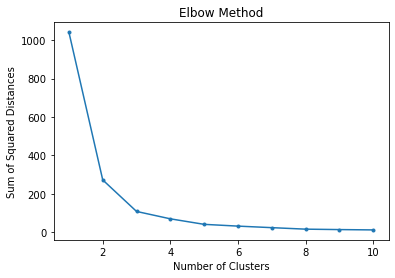

In [343]:
# Now after splitting the data, we start making the clusters.

# First thing we need is the number of clusters
# To do that we Use elbow method
# we goto all the clusters, list to store all sum of squared distances
ssd = []

# Fit KMeans models for values of k from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    predicted = kmeans.fit_predict(testingMoviesDf1[['genres','popularity']])
    ssd.append(kmeans.inertia_)

# Plot the relationship between k and sum of squared distances
plt.plot(range(1, 11), ssd, marker='.')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()


# As we can see the elbow occurs between 3 and 4, so we pick 4
# as an optimal number of clusters

In [344]:
# Experiment 1, Number of clusters chosen to be 4
numCluster = 4

# run the clusterting for 4 clusters
kmeans = KMeans(n_clusters=numCluster)
predicted = kmeans.fit_predict(testingMoviesDf1[['genres','popularity']])

In [345]:
# we add the predictions into the dataframe
testingMoviesDf1.loc[:, 'cluster'] = predicted
testingMoviesDf1.head()

C:\Users\Aakash\AppData\Local\Temp\ipykernel_16400\3559689664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testingMoviesDf1.loc[:, 'cluster'] = predicted


,genres,id,popularity,production_countries,title,vote_average,vote_count,cluster
0,0.638809,862,0.040087,"[{'iso_3166_1': 'US', 'name': 'United States o...",Toy Story,0.77,0.384725,2
1,0.398655,8844,0.031079,"[{'iso_3166_1': 'US', 'name': 'United States o...",Jumanji,0.69,0.171439,1
2,0.201729,15602,0.021394,"[{'iso_3166_1': 'US', 'name': 'United States o...",Grumpier Old Men,0.65,0.006536,3
3,0.055235,31357,0.007049,"[{'iso_3166_1': 'US', 'name': 'United States o...",Waiting to Exhale,0.61,0.002416,0
4,0.048031,11862,0.015320,"[{'iso_3166_1': 'US', 'name': 'United States o...",Father of the Bride Part II,0.57,0.012291,0


Text(0, 0.5, 'popularity')

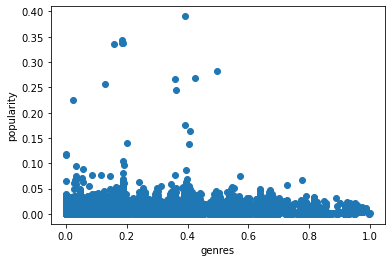

In [346]:
# Now we see all the points in our data and the the points in each cluster
# plotting the sliced data
plt.scatter(testingMoviesDf1.genres, testingMoviesDf1.popularity)
plt.xlabel('genres')
plt.ylabel('popularity')

Number of points in each cluster
cluster1= 11369
cluster2= 3293
cluster3= 2753
cluster4= 5045
Input Value belongs to cluster= 1


C:\Users\Aakash\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


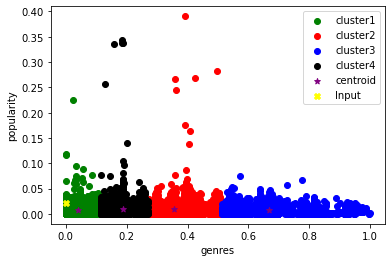

In [347]:
# Now,we plot the results on the scatter plot
df1 = testingMoviesDf1[testingMoviesDf1.cluster == 0] #all points where cluster is 0
df2 = testingMoviesDf1[testingMoviesDf1.cluster == 1] #all points where cluster is 1
df3 = testingMoviesDf1[testingMoviesDf1.cluster == 2] #all points where cluster is 2
df4 = testingMoviesDf1[testingMoviesDf1.cluster == 3] #all points where cluster is 3


# number of points in each cluster
print("Number of points in each cluster")
print("cluster1=", len(df1))
print("cluster2=", len(df2))
print("cluster3=", len(df3))
print("cluster4=", len(df4))
# Plotting the clusters
# plot each cluster point with different colors
plt.scatter(df1.genres, df1.popularity, color ='green', label='cluster1')
plt.scatter(df2.genres, df2.popularity, color ='red', label='cluster2')
plt.scatter(df3.genres, df3.popularity, color ='blue', label='cluster3')
plt.scatter(df4.genres, df4.popularity, color ='black', label='cluster4')


plt.xlabel('genres')
plt.ylabel('popularity')


# plot the centres
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='purple', marker='*', label='centroid')



# Now that we have the clusters
# We pick the movie and predict the clusters for that movie
inputMovie = testingMoviesDf1[['genres', 'popularity']].iloc[2000] # pick the movie at index 2000
inputCluster = kmeans.predict([inputMovie])
print("Input Value belongs to cluster=", inputCluster[0]+1)
#plotting the input data
plt.scatter(inputMovie[0], inputMovie[1], color='yellow', marker='X', label='Input')
plt.legend()

In [348]:
# This was phase 1 of experiment 1
# The cluster where our input movie belongs is the one, where all the similar movies belong.
# Now we'll make a transaction databse of the movies in this cluster.
# Meaning, tId = [[x where x is all movies in the cluster watched by a single user] for all the users]
# These are the movies in that cluster
similarMovies = testingMoviesDf1[testingMoviesDf1['cluster'] == inputCluster[0]]
similarMovies.head()

,genres,id,popularity,production_countries,title,vote_average,vote_count,cluster
3,0.055235,31357,0.007049,"[{'iso_3166_1': 'US', 'name': 'United States o...",Waiting to Exhale,0.61,0.002416,0
4,0.048031,11862,0.015320,"[{'iso_3166_1': 'US', 'name': 'United States o...",Father of the Bride Part II,0.57,0.012291,0
6,0.072046,11860,0.012196,"[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",Sabrina,0.62,0.010018,0
10,0.055235,9087,0.011541,"[{'iso_3166_1': 'US', 'name': 'United States o...",The American President,0.65,0.014139,0
11,0.076849,12110,0.009919,"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",Dracula: Dead and Loving It,0.57,0.014920,0


In [349]:
# Now we make the transaction db and pass these movies to an apriori algorithm
# Making transactions, list of userIds for each movieId in out recommendations
transactions = dict()

for i in range(len(similarMovies)):
    transactions[similarMovies.iloc[i]['title']] = list(testingRatingsDf1[testingRatingsDf1['movieId'] 
                                                                       == similarMovies.iloc[i]['id']]['userId'])
    if len(transactions[similarMovies.iloc[i]['title']]) == 0:
        del transactions[similarMovies.iloc[i]['title']]
        
        
# Printing MovieName, [UserIds who rated it]
for i in transactions:
    print(i, transactions[i])

Casino [24, 43, 71, 120, 122, 125, 150, 189, 191, 193, 201, 250, 306, 374, 390, 400, 407, 433, 447, 461, 463, 533, 595, 611, 614, 624, 633, 641, 651, 741, 799, 806, 819, 829, 836, 850, 851, 865, 925, 937, 1010, 1037, 1041, 1055, 1057, 1074, 1080, 1093, 1136, 1143, 1152, 1154, 1178, 1195, 1368, 1398, 1547, 1555, 1576, 1587, 1602, 1626, 1641, 1647, 1679, 1691, 1709, 1740, 1764, 1799, 1802, 1817, 1832, 1867, 1903, 1934, 1937, 1974, 2003, 2007, 2060, 2115, 2123, 2139, 2149, 2170, 2172, 2202, 2203, 2220, 2237, 2248, 2405, 2441, 2452, 2468, 2469, 2477, 2496, 2515, 2537, 2607, 2617, 2642, 2649, 2680, 2705, 2708, 2723, 2733, 2792, 2855, 2932, 2970, 3018, 3019, 3021, 3055, 3057, 3071, 3089, 3140, 3143, 3153, 3157, 3158, 3162, 3163, 3204, 3251, 3278, 3281, 3287, 3319, 3379, 3423, 3437, 3457, 3468, 3473, 3482, 3494, 3558, 3567, 3646, 3658, 3684, 3724, 3735, 3744, 3780, 3807, 3817, 3960, 4012, 4038, 4059, 4094, 4095, 4160, 4186, 4227, 4266, 4284, 4294, 4348, 4405, 4498, 4501, 4512, 4515, 4582, 458

Ordet [8659]
Forbidden Games [2520, 4160, 5172, 6513, 8563, 8659, 9007]
The Passion of Joan of Arc [2, 20, 30, 33, 34, 37, 40, 43, 46, 49, 50, 52, 56, 59, 62, 63, 65, 67, 74, 75, 82, 87, 98, 99, 101, 105, 112, 115, 118, 120, 125, 131, 142, 150, 153, 158, 160, 164, 178, 179, 181, 188, 191, 193, 196, 215, 217, 218, 222, 225, 228, 229, 230, 231, 235, 248, 251, 261, 267, 269, 271, 273, 282, 284, 312, 316, 317, 318, 319, 321, 323, 325, 330, 332, 334, 338, 339, 340, 342, 352, 359, 362, 365, 366, 368, 387, 389, 390, 392, 395, 398, 400, 418, 425, 426, 427, 429, 430, 431, 432, 436, 443, 454, 455, 465, 468, 471, 474, 479, 480, 482, 483, 487, 490, 494, 501, 503, 506, 511, 518, 523, 524, 527, 533, 544, 545, 558, 559, 565, 567, 580, 581, 582, 586, 592, 595, 600, 603, 611, 613, 615, 622, 633, 635, 638, 641, 646, 661, 663, 672, 673, 674, 682, 686, 690, 701, 702, 703, 715, 717, 719, 721, 724, 727, 728, 729, 732, 733, 739, 740, 741, 742, 748, 750, 751, 755, 757, 760, 765, 766, 772, 775, 778, 790, 800, 

Le Beau Serge [229, 2649, 5148]
Night Catches Us [429, 7107]
7 Virgins [19, 24, 46, 150, 193, 362, 463, 465, 633, 682, 726, 811, 882, 906, 925, 971, 1010, 1145, 1191, 1214, 1274, 1380, 1422, 1465, 1729, 1740, 1748, 1885, 1932, 1998, 2016, 2046, 2202, 2269, 2354, 2364, 2381, 2408, 2448, 2453, 2477, 2515, 2537, 2547, 2617, 2627, 2664, 2742, 2743, 2750, 2792, 2820, 2981, 3019, 3076, 3107, 3133, 3153, 3167, 3198, 3249, 3251, 3278, 3292, 3366, 3436, 3437, 3494, 3498, 3534, 3539, 3558, 3567, 3586, 3605, 3672, 3673, 3694, 3817, 3942, 3950, 4018, 4020, 4032, 4052, 4066, 4122, 4160, 4193, 4294, 4302, 4305, 4384, 4426, 4493, 4515, 4596, 4635, 4673, 4767, 4831, 4850, 4856, 4966, 4988, 5009, 5021, 5079, 5102, 5154, 5251, 5274, 5378, 5384, 5418, 5461, 5508, 5523, 5555, 5565, 5621, 5625, 5695, 5710, 5732, 5776, 5797, 5798, 5812, 5829, 5866, 5875, 5919, 5921, 5985, 6142, 6201, 6294, 6301, 6363, 6420, 6422, 6426, 6448, 6500, 6583, 6697, 6770, 6789, 6803, 6914, 6948, 6987, 7069, 7076, 7094, 7122, 7157,

In [350]:
# so these transactions are        movieID : [userIDss], 
# Now we want to convert it to     userId :  [moviesIds]
#Making the vertical Database
from collections import defaultdict

original_dict = transactions
vertical_dict = defaultdict(list)

for key, values in original_dict.items():
    for value in values:
        vertical_dict[value].append(key)
        
for i in vertical_dict:
    vertical_dict[i] = list(vertical_dict[i])

transactions = [vertical_dict[i] for i in vertical_dict]
transactions = [[str(item) for item in transaction] for transaction in transactions]
transactions

[['Casino',
  'Once Were Warriors',
  'Three Colors: Red',
  'While You Were Sleeping',
  'Addams Family Values',
  'Mrs. Doubtfire',
  'The Remains of the Day',
  'Sleepless in Seattle',
  'Jack & Sarah',
  "Breakfast at Tiffany's",
  'Cat on a Hot Tin Roof',
  'Romeo + Juliet',
  'The Double Life of Veronique',
  'Tie Me Up! Tie Me Down!',
  'Heathers',
  'Michael',
  'Benny & Joon',
  'Fools Rush In',
  'Addicted to Love',
  'Contempt',
  'Swept from the Sea',
  'The Breakfast Club',
  'Stage Fright',
  'Young and Innocent',
  'Married to the Mob',
  'Say Anything...',
  'American History X',
  'Gods and Monsters',
  'Rocky V',
  'Office Space',
  'American Pie',
  'Arlington Road',
  'Barry Lyndon',
  'The 400 Blows',
  'Frances',
  'Children of Paradise',
  'Fight Club',
  'A River Runs Through It',
  'Twin Peaks: Fire Walk with Me',
  'My Tutor',
  'American Graffiti',
  "Jacob's Ladder",
  'Dancer in the Dark',
  'The Million Dollar Hotel',
  'Ariel',
  'Bagdad Cafe',
  'America

In [351]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

dfFinal = pd.DataFrame(te_ary, columns=te.columns_)

# Run Apriori with a minimum support
frequent_itemsets = apriori(dfFinal, min_support=0.04, use_colnames=True)

max_length_idx = frequent_itemsets['itemsets'].apply(len).idxmax()
max_length_string = frequent_itemsets.loc[max_length_idx, 'itemsets']
finalSuggestions = list(max_length_string)
finalSuggestions # these are the final suggestions from the model 1

['Cockles and Muscles',
 'Monsoon Wedding',
 'The Million Dollar Hotel',
 'Rain Man',
 'Three Colors: Red',
 'The Hours']

32087
Number of points in each cluster
cluster1= 9131
cluster2= 3614
cluster3= 16754
cluster4= 2588
Input Value belongs to cluster= 1


C:\Users\Aakash\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


['Back to the Future Part II',
 'Batman Returns',
 'The Conversation',
 'Silent Hill',
 'Bang, Boom, Bang',
 'Terminator 3: Rise of the Machines']

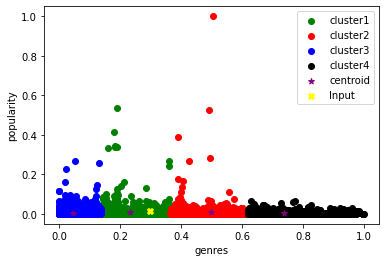

In [352]:
# Experiment 1, Evaluation
# For testing we use the original DataFrames,
# Run the same algorithm, get the result
# Then we find the precision and recall rates for our User

# Experiment 1, Number of clusters chosen to be 4
numCluster = 4

# run the clusterting for 4 clusters
kmeans = KMeans(n_clusters=numCluster)
predicted = kmeans.fit_predict(moviesDf[['genres','popularity']])

# we add the predictions into the dataframe
moviesDf.loc[:, 'cluster'] = predicted
print(len(moviesDf))

# Now,we plot the results on the scatter plot
df1 = moviesDf[moviesDf.cluster == 0] #all points where cluster is 0
df2 = moviesDf[moviesDf.cluster == 1] #all points where cluster is 1
df3 = moviesDf[moviesDf.cluster == 2] #all points where cluster is 2
df4 = moviesDf[moviesDf.cluster == 3] #all points where cluster is 3


# number of points in each cluster
print("Number of points in each cluster")
print("cluster1=", len(df1))
print("cluster2=", len(df2))
print("cluster3=", len(df3))
print("cluster4=", len(df4))
# Plotting the clusters
# plot each cluster point with different colors
plt.scatter(df1.genres, df1.popularity, color ='green', label='cluster1')
plt.scatter(df2.genres, df2.popularity, color ='red', label='cluster2')
plt.scatter(df3.genres, df3.popularity, color ='blue', label='cluster3')
plt.scatter(df4.genres, df4.popularity, color ='black', label='cluster4')


plt.xlabel('genres')
plt.ylabel('popularity')


# plot the centres
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='purple', marker='*', label='centroid')



# Now that we have the clusters
# We pick the movie and predict the clusters for that movie
inputMovie = moviesDf[['genres', 'popularity']].iloc[movieIndex] # pick the movie at index 32000 from the testingData
inputCluster = kmeans.predict([inputMovie])
print("Input Value belongs to cluster=", inputCluster[0]+1)
#plotting the input data
plt.scatter(inputMovie[0], inputMovie[1], color='yellow', marker='X', label='Input')
plt.legend()

similarMovies = moviesDf[moviesDf['cluster'] == inputCluster[0]]
similarMovies.head()


# Making transactions, list of userIds for each movieId in out recommendations
transactions = dict()

for i in range(len(similarMovies)):
    transactions[similarMovies.iloc[i]['title']] = list(ratingsDf[ratingsDf['movieId'] 
                                                                       == similarMovies.iloc[i]['id']]['userId'])
    if len(transactions[similarMovies.iloc[i]['title']]) == 0:
        del transactions[similarMovies.iloc[i]['title']]
        
    
    
from collections import defaultdict

original_dict = transactions
vertical_dict = defaultdict(list)

for key, values in original_dict.items():
    for value in values:
        vertical_dict[value].append(key)
        
for i in vertical_dict:
    vertical_dict[i] = list(vertical_dict[i])

transactions = [vertical_dict[i] for i in vertical_dict]
transactions = [[str(item) for item in transaction] for transaction in transactions]

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

dfFinal = pd.DataFrame(te_ary, columns=te.columns_)

# Run Apriori with a minimum support
frequent_itemsets = apriori(dfFinal, min_support=0.04, use_colnames=True)

max_length_idx = frequent_itemsets['itemsets'].apply(len).idxmax()
max_length_string = frequent_itemsets.loc[max_length_idx, 'itemsets']
finalSuggestions = list(max_length_string)
finalSuggestions # these are the final suggestions from the model 1

In [353]:
# For Evluation Matrix, I'll need the list of all movies the user watched
history = []
userH = ratingsDf[ratingsDf['userId'] == userId]

# Join the two dataframes on 'movieId' column
merged_df = pd.merge(userH, moviesDf, left_on='movieId', right_on = 'id')

# Get all the movie names
movie_names = merged_df['title'].unique()

# Print the movie names
for name in movie_names:
    history.append(name)

history

['Judgment Night',
 'Three Colors: Red',
 '48 Hrs.',
 'Back to the Future Part II',
 'A Clockwork Orange',
 'Star Trek: Generations',
 'Syriana',
 'The 39 Steps',
 'High Noon',
 'Terminator 3: Rise of the Machines',
 'Grill Point',
 'Grbavica: The Land of My Dreams',
 'The Million Dollar Hotel',
 'Monsieur Ibrahim',
 'Eyes Wide Shut',
 'Cockles and Muscles',
 'Batman Returns',
 'A Nightmare on Elm Street',
 'Rain Man',
 'Tough Enough',
 'Popular Music',
 'Bend It Like Beckham',
 'Monsoon Wedding',
 'Notting Hill',
 'Once Were Warriors',
 'Psycho',
 'The Man with the Golden Arm',
 'The Hours',
 'The Conversation',
 'Solaris',
 'The Grapes of Wrath',
 'Titanic',
 'Interview with the Vampire',
 'Beauty and the Beast',
 'A View to a Kill',
 "Monsieur  Hulot's Holiday",
 'The Passion of Joan of Arc',
 'Sleepless in Seattle',
 'Cool Hand Luke',
 'The Thomas Crown Affair',
 'The Great Dictator',
 'Cars',
 'Dawn of the Dead',
 'Madagascar',
 'The Hidden Fortress',
 'Point Break',
 'The Thirtee

In [354]:
# Now that we have userHistory and finalSuggestions, we find the common among both
common = [i for i in history if i in finalSuggestions]

precisionR = len(common)/len(history)
recallR = len(common)/len(finalSuggestions)

print("precisionRate=",precisionR)
print("recallRate=",recallR)

precisionRate= 0.038461538461538464
recallRate= 0.6666666666666666


In [24]:
# As both precision rate and recall rate are not that high
# We'll now try another approach
# Experiment 1 ends----------------------------------------------------------------

In [355]:
# Experiment 2 begins--------------------------------------------------------------
"""
The approach we are using here is very different from the previous one.
The previous approach focuses on the movie and not the user.
In this case, we'll give both user and the movie some weight in the final recommendation.
The approach we r using here is that, similar users watch similar movies.
So now we run clustering algorithm on 2 times. Ones on the user,
and the other time on the movie.
So we get 2 clusters, one of similar movies and one of similar users.
Then for a list of similar movies,
We find the biggest subset watched by most similar users.
By most, we mean at least 70% similar users have watched that subset.
This value right now is chosen randomly, no specific reason to pick it.
"""

# step 1 , make clusters for both moviesDf and usersDf
numCluster = 4

ratingsCopy = ratingsDf.copy()

#scale data in this copy
scaler = MinMaxScaler()
scaler.fit(ratingsCopy[['rating']])
ratingsCopy[['rating']] = scaler.transform(ratingsCopy[['rating']])

scaler.fit(ratingsCopy[['movieId']])
ratingsCopy[['movieId']] = scaler.transform(ratingsCopy[['movieId']])

Number of points in each cluster
cluster1 7204
cluster2 2354
cluster3 3714
cluster4 1056
cluster5 1542
cluster6 8822
cluster7 2142
cluster8 5253
Input Value belongs to cluster= 3


C:\Users\Aakash\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


,genres,id,popularity,production_countries,title,vote_average,vote_count,cluster
17,0.297791,5,0.016487,"[{'iso_3166_1': 'US', 'name': 'United States o...",Four Rooms,0.65,0.038295,2
18,0.301633,9273,0.014987,"[{'iso_3166_1': 'US', 'name': 'United States o...",Ace Ventura: When Nature Calls,0.61,0.080142,2
32,0.230548,78802,0.001362,"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",Wings of Courage,0.68,0.000284,2
64,0.261143,755,0.028017,"[{'iso_3166_1': 'US', 'name': 'United States o...",From Dusk Till Dawn,0.69,0.116803,2
70,0.283381,9102,0.023304,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",Screamers,0.61,0.010941,2


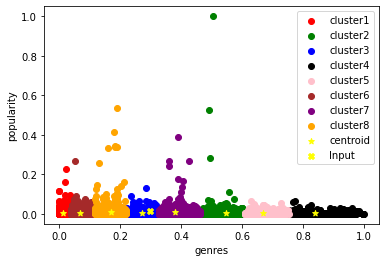

In [356]:
kmeans = KMeans(n_clusters=numCluster*2)
predictedMovies = kmeans.fit_predict(moviesDf[['genres','popularity']])

# we add the predictions into the dataframe
moviesDf.loc[:, 'cluster'] = predictedMovies

# Now,we plot the results on the scatter plot
print("Number of points in each cluster")

COLORS = ['red', 'green', 'blue', 'black', 'pink', 'brown', 'purple', 'orange']
for i in range(numCluster*2):
    df1 = moviesDf[moviesDf.cluster == i] #all points where cluster is 0


    # number of points in each clusters
    print("cluster" + str(i+1), len(df1))
    
    # Plotting the clusters
    # plot each cluster point with different colors
    plt.scatter(df1.genres, df1.popularity, color =COLORS[i], label='cluster'+str(i+1))
    

plt.xlabel('genres')
plt.ylabel('popularity')


# plot the centres
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='yellow', marker='*', label='centroid')



# Now that we have the clusters
# We pick the movie and predict the clusters for that movie
inputMovie = moviesDf[['genres', 'popularity']].iloc[movieIndex] # pick the movie at index 32000 from the testingData
inputCluster = kmeans.predict([inputMovie])
print("Input Value belongs to cluster=", inputCluster[0]+1)
#plotting the input data
plt.scatter(inputMovie[0], inputMovie[1], color='yellow', marker='X', label='Input')
plt.legend()

similarMovies = moviesDf[moviesDf['cluster'] == inputCluster[0]]
similarMovies.head()

Number of points in each cluster
cluster1 2085
cluster2 716
cluster3 2461
cluster4 800
cluster5 183
cluster6 2604
cluster7 1703
cluster8 104
Input Value belongs to cluster= 7


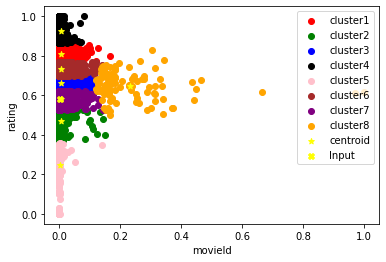

In [357]:
# Now we check where the user belongs among all users
# Now,we plot the results on the scatter plot

new_df = ratingsCopy.groupby('userId').agg({'movieId': 'sum', 'rating': 'mean'}).reset_index()
#scale data in this copy
scaler = MinMaxScaler()
scaler.fit(new_df[['rating']])
new_df[['rating']] = scaler.transform(new_df[['rating']])

scaler.fit(new_df[['movieId']])
new_df[['movieId']] = scaler.transform(new_df[['movieId']])

kmeans = KMeans(n_clusters=numCluster*2)
predictedUsers =  kmeans.fit_predict(new_df[['movieId','rating']])
new_df.loc[:, 'cluster'] = predictedUsers

print("Number of points in each cluster")
for i in range(numCluster*2):
    userdf1 = new_df[new_df.cluster == i] #all points where cluster is 0

    # number of points in each cluster
    print("cluster" +str(i+1), len(userdf1))


    # Plotting the clusters
    # plot each cluster point with different colors
    plt.scatter(userdf1.movieId, userdf1.rating, color =COLORS[i], label='cluster'+str(i+1))


plt.xlabel('movieId')
plt.ylabel('rating')


# plot the centres
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='yellow', marker='*', label='centroid')


# finding the right cluster for my user
# In this case, we give that index where the user watched the input movie
movieId = moviesDf.iloc[movieIndex]['id']


inputRating = new_df[new_df['userId'] == userId] # pick the movie at index 32000 from the testingData
inputCluster = kmeans.predict(inputRating[['movieId','userId']])


print("Input Value belongs to cluster=", int(inputRating.iloc[0]['cluster'])+1)
plt.scatter([inputRating['movieId']], [inputRating['rating']], color='yellow', marker='X', label='Input')
plt.legend()

similarUsers = new_df[new_df['cluster'] == int(inputRating.iloc[0]['cluster'])]

In [363]:
movieIds = []
similarUserIds = list(similarUsers['userId'])
similarMovieId = list(similarMovies['id'])

filtered_df = ratingsDf[ratingsDf['userId'].isin(similarUserIds)]
moreFiltered = filtered_df[filtered_df['movieId'].isin(similarMovieId)]

duplicates = moreFiltered.groupby('movieId').filter(lambda x: len(x) > 0.025*len(similarUserIds))
finalIds = list(duplicates['movieId'].unique())

In [364]:
finalRecommendations = list(moviesDf[moviesDf['id'].isin(finalIds)]['title'])
finalRecommendations

# For Evluation Matrix, I'll need the list of all movies the user watched
history = []
userH = ratingsDf[ratingsDf['userId'] == userId]

# Join the two dataframes on 'movieId' column
merged_df = pd.merge(userH, moviesDf, left_on='movieId', right_on = 'id')

# Get all the movie names
movie_names = merged_df['title'].unique()

# Print the movie names
for name in movie_names:
    history.append(name)

# Now that we have userHistory and finalSuggestions, we find the common among both
common = [i for i in history if i in finalRecommendations]

precisionR = len(common)/len(history)
recallR = len(common)/len(finalRecommendations)

print("precisionRate=",precisionR)
print("recallRate=",recallR)

precisionRate= 0.1346153846153846
recallRate= 0.22580645161290322


In [365]:
# As we can see these are the precision and recall rate and quite different from Experiment 1
# Hence, Experiment 2 ends here--------------------------------------------

# Conclusion
# As Approach 1, didn't focus on user history, the results were not precise.
# But as Approach 2, focused on the user history too, the results were more precise.
# --------------------------------------------------------------------------------------------